# Plotting Taufik phase-autonomy stats

This simply imports Taufik's phase autonomy stats from his MATLAB code and plots it relative to clinician onsets

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import os
#import mne
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
import sys
from scipy import stats
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook

In [2]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [3]:
# Load Taufik stats
tv_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/TAUFIK_RESULTS/Processed/NA_d1_sz2_F/NA_d1_sz2_F.mat'
#tv_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/TAUFIK_RESULTS/Processed_HILBERT/NA_d1_sz2_F/Page-Hinkley_early/NA_d1_sz2-PH.mat'
mat=scipy.io.loadmat(tv_fname)
mat.keys()

dict_keys(['matrix_mo', '__header__', 'matrix_bi', '__globals__', 'cfg', 'Sf', 'group_end_index', 'F', '__version__'])

In [4]:
# Take max F value across frequencies
sum_stat='max'
F=mat['F']
if sum_stat=='max':
    Fmax=np.max(F,axis=0) # This is what Taufik uses
else:
    Fmax=np.mean(F,axis=0) # This highlights szr better and keeps onset peak
# Fmax=np.median(F,axis=0) # This highlights szr better, but loses onset peak
Fmax.shape

(93500, 31)

In [5]:
# Import Clinical Szr Onset Times
sub='NA'
if sys.platform=='linux':
    onset_csv_dir='/home/dgroppe/TWH_INFO/CLINICIAN_ONSET_TIMES/'
else:
    onset_csv_dir='/Users/davidgroppe/Dropbox/TWH_INFO/CLINICIAN_ONSET_TIMES/'
#onset_csv_dir='ONSET_TIMES_CLINICAL/'
onset_csv_fname=os.path.join(onset_csv_dir,sub+'_clinician_onset_offset.csv')
print('Importing file %s' % onset_csv_fname)
onset_df=pd.read_csv(onset_csv_fname)

Importing file /Users/davidgroppe/Dropbox/TWH_INFO/CLINICIAN_ONSET_TIMES/NA_clinician_onset_offset.csv


In [6]:
onset_df.head()

,DAY,SZR#,ONSET,OFFSET,SOZ_CHAN,FILE_ONSET,DDMMYR,SRATE_HZ,NOTES,ONSET_SEC,FILE_ONSET_SEC,ONSET_TPT,DG_ONSET_CHAN,USE4CLASSIFIER
0,1,1,8:59:03 PM,9:38:35 PM,?,?,06/23/2009,500,?,75543,NaN,NaN,?,noEEGdata
1,1,2,1:54:41 AM,1:55:52 AM,RHD1,1:52:45,06/23/2009,500,?,6881,6765.0,58000.0,RHD1-2,use
2,1,3,2:42:25 AM,2:43:58 AM,?,2:39:36,06/23/2009,500,?,9745,9576.0,84500.0,RHD1-2,use
3,1,4,4:51:59 AM,4:53:35 AM,?,4:49:03,06/23/2009,500,?,17519,17343.0,88000.0,RHD1-2,use
4,1,5,6:29:14 AM,6:31:11 AM,?,6:26:20,06/23/2009,500,?,23354,23180.0,87000.0,RHD1-2,use


In [7]:
def clin_onset_tpt(szr_name, onset_df):
    import re
    name_splt=szr_name.split('_')
    day=int(name_splt[1][1:])
    szr=int(re.findall('[0-9]+',name_splt[2])[0])
    print('Getting clinical onset time for %s: Day %d, Szr %d' % (name_splt[0],day,szr))

    # temp_df=onset_df[onset_df['DAY']==day and onset_df['SZR#']==2]
    day_ids=onset_df[onset_df['DAY']==day].index 
    szr_ids=onset_df[onset_df['SZR#']==szr].index 
    use_id=day_ids.intersection(szr_ids)
    onset_tpt=onset_df['ONSET_TPT'].iloc[use_id].values[0]
    return onset_tpt

szr_name='NA_d1_sz2.mat'
onset_tpt=clin_onset_tpt(szr_name, onset_df)

Getting clinical onset time for NA: Day 1, Szr 2


In [8]:
# Import Data
szr_name='NA_d1_sz2.mat'
# if sys.platform=='linux':
#     ieeg_root='/home/dgroppe/TWH_EEG'
# else:
#     ieeg_root='/Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/'
path_dict=ief.get_path_dict()
ieeg_root=path_dict['ieeg_root']
#ieeg_dir=os.path.join(ieeg_root,sub,'Data')
ieeg_dir=os.path.join(ieeg_root,sub,'EEG_MAT')
ieeg_fname=os.path.join(ieeg_dir,szr_name)
print('Loading %s' % ieeg_fname)
mat=scipy.io.loadmat(ieeg_fname)
Sf=mat['Sf'][0]
ieeg=mat['matrix_bi']
ieeg=ieeg.T
n_chan, n_tpt=ieeg.shape
tpts_sec=np.arange(0,n_tpt)/Sf
tpts_sec=tpts_sec.T
# Import Channel Labels
chan_fname=os.path.join(ieeg_root,sub,
                        sub+'_channel_info.csv')
print('Loading %s' % chan_fname)
chan_labels_df=pd.read_csv(chan_fname,names=['label'])
# Convert to list and remove redundant electrode stem for second electrode in each bipolar pair
chan_labels=ief.clean_labels(list(chan_labels_df['label']))

#Whiten data
# ieeg[:,1:]=ieeg[:,1:]-ieeg[:,-1:]
# ieeg[:,0]=0

onset_chan_id=12; #RHD1-2
contralat_chan_id=0; #LHD1-2

Loading /Users/davidgroppe/ONGOING/TWH_EEG/NA/EEG_MAT/NA_d1_sz2.mat
Loading /Users/davidgroppe/ONGOING/TWH_EEG/NA/NA_channel_info.csv


In [9]:
# List channel names
for ct, chan_str in enumerate(chan_labels):
    print('%d: %s' % (ct,chan_str))

0: LHD1-2
1: LHD2-3
2: LHD3-4
3: LAT1-2
4: LAT2-3
5: LAT3-4
6: LMT1-2
7: LMT2-3
8: LMT3-4
9: LPT1-2
10: LPT2-3
11: LPT3-4
12: RHD1-2
13: RHD2-3
14: RHD3-4
15: RAT1-2
16: RAT2-3
17: RAT3-4
18: RMT1-2
19: RMT2-3
20: RMT3-4
21: RSPT1-2
22: RSPT2-3
23: RSPT3-4
24: RSPT4-5
25: RSPT5-6
26: RIPT1-2
27: RIPT2-3
28: RIPT3-4
29: RIPT4-5
30: RIPT5-6


<IPython.core.display.Javascript object>


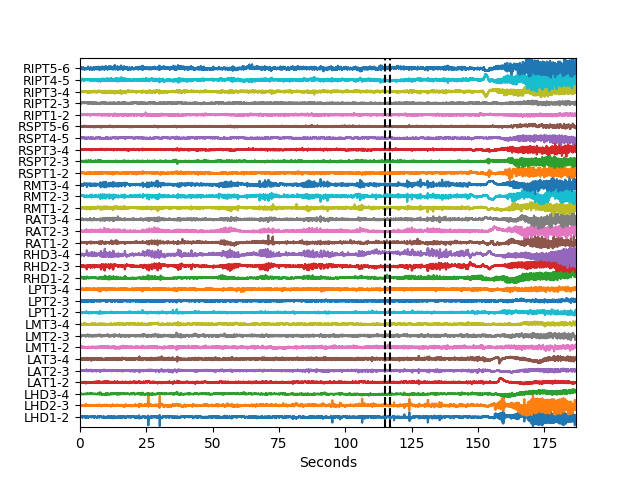

In [10]:
# Plot voltage time series and onset
[h, ax]=ief.strat_plot(ieeg,chan_labels,tpts_sec=tpts_sec)

onset_upper_bnd_sec=(onset_tpt/Sf)+1
onset_lower_bnd_sec=(onset_tpt/Sf)-1
ylim=ax.get_ylim()
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')

<IPython.core.display.Javascript object>


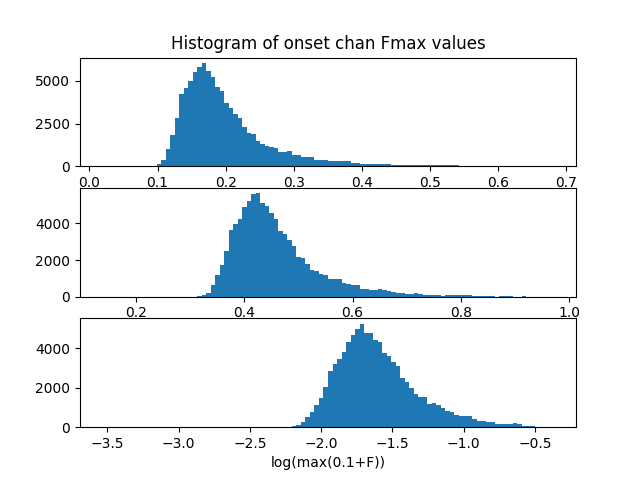

In [11]:
# Figure out how to best normalize max(F) values by plotting various
# histograms of Fmax values
plt.figure(7)
plt.clf()
plt.subplot(3,1,1)
_=plt.hist(Fmax[:,onset_chan_id],bins=100)
plt.title('Histogram of onset chan Fmax values')
plt.xlabel('max(F)')

plt.subplot(3,1,2)
_=plt.hist(dg.asin_trans(Fmax[:,onset_chan_id]),bins=100)
plt.xlabel('asin(max(F))')

plt.subplot(3,1,3)
_=plt.hist(np.log(0.01+Fmax[:,onset_chan_id]),bins=100)
plt.xlabel('log(max(0.1+F))')

<IPython.core.display.Javascript object>


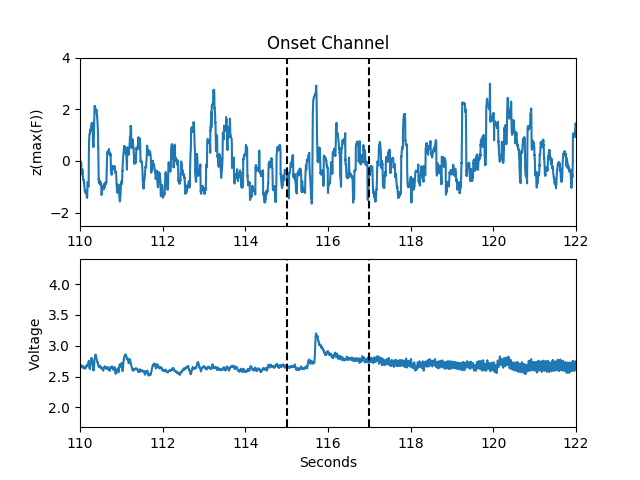

In [12]:
# Plot max(F)-baseline z-normalized just a few seconds around the onset window
#Fmax_z=dg.asin_trans(Fmax[:,onset_chan_id:onset_chan_id+1].copy())
Fmax_z=np.log(0.01+Fmax[:,onset_chan_id:onset_chan_id+1].copy())
ief.z_norm(Fmax_z.T,tpts_sec,onset_lower_bnd_sec)
plt.figure(5)  
plt.clf()
plt.subplot(2,1,1)
handles=plt.plot(tpts_sec,Fmax_z)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim([-2.5, 4])
# plt.ylim(ylim)
#plt.xlim([bp_coh_sec[0], onset_upper_bnd_sec])
plt.xlim([onset_lower_bnd_sec-5, onset_upper_bnd_sec+5])
# plt.legend(handles,band_labels,loc='lower left')
if sum_stat=='max':
    plt.ylabel('z(max(F))')
else:
    plt.ylabel('z(mean(F))')
plt.title('Onset Channel')

# Plot raw data a few seconds around the onset window
# plt.figure(6)
# plt.clf()
plt.subplot(2,1,2)
handles=plt.plot(tpts_sec,ieeg[onset_chan_id,:])
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
# plt.ylim([.8, 1])
plt.ylim(ylim)
#plt.xlim([bp_coh_sec[0], onset_upper_bnd_sec])
plt.xlim([onset_lower_bnd_sec-5, onset_upper_bnd_sec+5])
# plt.legend(handles,band_labels,loc='lower left')
plt.xlabel('Seconds')
plt.ylabel('Voltage')

<IPython.core.display.Javascript object>


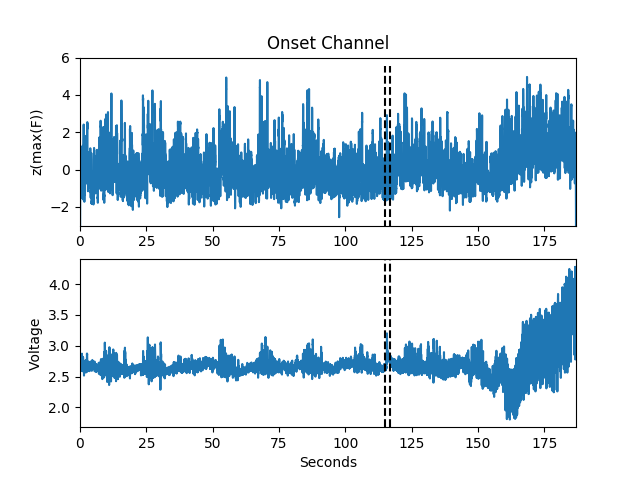

In [13]:
# Plot max(F)-baseline z-normalized at all time points
#Fmax_z=dg.asin_trans(Fmax[:,onset_chan_id:onset_chan_id+1].copy())
Fmax_z=np.log(0.01+Fmax[:,onset_chan_id:onset_chan_id+1].copy())
ief.z_norm(Fmax_z.T,tpts_sec,onset_lower_bnd_sec)
plt.figure(6)  
plt.clf()
plt.subplot(2,1,1)
handles=plt.plot(tpts_sec,Fmax_z)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim([-3, 6])
#plt.ylim(ylim)
plt.xlim([tpts_sec[0], tpts_sec[-1]])
#plt.xlim([onset_lower_bnd_sec-5, onset_upper_bnd_sec+5])
# plt.legend(handles,band_labels,loc='lower left')
if sum_stat=='max':
    plt.ylabel('z(max(F))')
else:
    plt.ylabel('z(mean(F))')
plt.title('Onset Channel')

# Plot raw data a few seconds around the onset window
# plt.figure(6)
# plt.clf()
plt.subplot(2,1,2)
handles=plt.plot(tpts_sec,ieeg[onset_chan_id,:])
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
# plt.ylim([.8, 1])
plt.ylim(ylim)
plt.xlim([tpts_sec[0], tpts_sec[-1]])
#plt.xlim([onset_lower_bnd_sec-5, onset_upper_bnd_sec+5])
# plt.legend(handles,band_labels,loc='lower left')
plt.xlabel('Seconds')
plt.ylabel('Voltage')